# Issues of docking and attempts to solve them
This notebook aims to highlight the difficulties in predicting binding modes and affinities using a single snapshot, e.g. coming from docking or docking in combination with minimization.<br>
We will demonstrate the differences in free energy prediction using single snapshots and full sampling using Langewin dynamics (MD).<br>
We will study two 2D model potentials:<br>

* Four-well potential with smooth local minima: $V_{smooth}(x) = \sum_{i=1}⁴ a_i \exp(-0.5*(v_i*(x-s_i)² + w_i*(y-s_i)²)$
* Four-well potential with roughness in each local minima (which better resembles high dimensional molecular systems): $V_{rugged}(x) = A_{smooth} V_{smooth}(x) + A_{rugged} \sum_{i=1}² (cos(m_i x) + cos(n_i y))$

The notebook contains the following steps:<br>

1. Defintion of potentials
2. Numerical calculation of average energy, entropy and free energy for each of the four wells (= binding modes) to define the ground truth. 
3. Perform docking (+ gradient descent minimizatio) multiple times and compare results with ground truth data
4. Perform MD simulations and compute thermodynamic quantities
5. Alternative approaches for calculating thermodynamic properties: Normal mode analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

***
### Units
Coordinates in Angstroem<br>
Temperature in factors of 298 K<br>
Mass in amu<br>
Time in ss<br>
Energies in kcal/mol<br>

In [2]:

cf_kT = 0.592                       # T=298K
cf_hbar_omega = 0.3105  
cf_hbar_omega_over_kT = 0.5245      # T=298K

-------------------------------

## Define potentials

In [3]:
class Potential:
    def __init__(self, rugged, a1, a2, a3, a4, v1, v2, v3, v4, s1, s2, s3, s4, w1, w2, w3, w4, n1=0.0, n2=0.0, n3=0.0, n4=0.0, asc=0.0, aadd=0.0):
        self.rugged = rugged
        self.asc = asc
        self.aadd = aadd
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.a4 = a4
        self.v1 = v1
        self.v2 = v2
        self.v3 = v3
        self.v4 = v4
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.s4 = s4
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.n1 = n1
        self.n2 = n2
        self.n3 = n3
        self.n4 = n4

    def V(self, xy):
        if xy.ndim == 2:
            x = xy[:,0]
            y = xy[:,1]
        else:
            x = xy[0]
            y = xy[1]
        v_sc1 = self.a1*np.exp(-0.5*(self.v1*(x-self.s1)*(x-self.s1) + self.w1*(y-self.s3)*(y-self.s3)))
        v_sc2 = self.a2*np.exp(-0.5*(self.v2*(x-self.s2)*(x-self.s2) + self.w2*(y-self.s3)*(y-self.s3)))
        v_sc3 = self.a3*np.exp(-0.5*(self.v3*(x-self.s1)*(x-self.s1) + self.w3*(y-self.s4)*(y-self.s4)))
        v_sc4 = self.a4*np.exp(-0.5*(self.v4*(x-self.s2)*(x-self.s2) + self.w4*(y-self.s4)*(y-self.s4)))
        v_bound = self.V_boundary(x, y)
        v_sc = v_sc1 + v_sc2 + v_sc3 + v_sc4 + v_bound
        if self.rugged:
            return self.asc*v_sc + self.aadd*self.V_add(x, y)
        else:    
            return v_sc
    
    def F(self, xy):
        x = xy[:,0]
        y = xy[:,1]
        f_sc1_x = self.a1*self.v1*(x-self.s1)*np.exp(-0.5*(self.v1*(x-self.s1)*(x-self.s1) + self.w1*(y-self.s3)*(y-self.s3)))
        f_sc1_y = self.a1*self.w1*(y-self.s3)*np.exp(-0.5*(self.v1*(x-self.s1)*(x-self.s1) + self.w1*(y-self.s3)*(y-self.s3)))
        f_sc2_x = self.a2*self.v2*(x-self.s2)*np.exp(-0.5*(self.v2*(x-self.s2)*(x-self.s2) + self.w2*(y-self.s3)*(y-self.s3)))
        f_sc2_y = self.a2*self.w2*(y-self.s3)*np.exp(-0.5*(self.v2*(x-self.s2)*(x-self.s2) + self.w2*(y-self.s3)*(y-self.s3)))
        f_sc3_x = self.a3*self.v3*(x-self.s1)*np.exp(-0.5*(self.v3*(x-self.s1)*(x-self.s1) + self.w3*(y-self.s4)*(y-self.s4)))
        f_sc3_y = self.a3*self.w3*(y-self.s4)*np.exp(-0.5*(self.v3*(x-self.s1)*(x-self.s1) + self.w3*(y-self.s4)*(y-self.s4)))
        f_sc4_x = self.a4*self.v4*(x-self.s2)*np.exp(-0.5*(self.v4*(x-self.s2)*(x-self.s2) + self.w4*(y-self.s4)*(y-self.s4)))
        f_sc4_y = self.a4*self.w4*(y-self.s4)*np.exp(-0.5*(self.v4*(x-self.s2)*(x-self.s2) + self.w4*(y-self.s4)*(y-self.s4)))
        f_bound_x, f_bound_y = self.F_boundary(x, y)
        f_sc = np.array([f_sc1_x + f_sc2_x + f_sc3_x + f_sc4_x + f_bound_x, f_sc1_y + f_sc2_y + f_sc3_y + f_sc4_y + f_bound_y]).T        
        if self.rugged:
            return self.asc*f_sc + self.aadd*self.F_add(x, y)
        else:    
            return f_sc
    
    def V_boundary(self, x, y):
        return np.power(x/8, 6) + np.power(y/8, 6)
    
    def F_boundary(self, x, y):
        return [-6/8*np.power(x/8, 7), -6/8*np.power(y/8, 7)]
    
    def V_add(self, x, y):
        return np.cos(self.n1*x) + np.cos(self.n2*x) + np.cos(self.n3*y) + np.cos(self.n4*y)
    
    def F_add(self, x, y):
        return np.array([self.n1*np.sin(self.n1*x) + self.n2*np.sin(self.n2*x), self.n3*np.sin(self.n3*y) + self.n4*np.sin(self.n4*y)]).T
    

In [4]:
a1 = -4.2
a2 = -4.7
a3 = -4.5
a4 = -4.1
v1 = 0.5
v2 = 1.2
v3 = 0.8
v4 = 1.0
w1 = 0.6
w2 = 1.3
w3 = 0.8
w4 = 1.1

s1 = -5.0
s2 =  5.0
s3 = -5.0
s4 =  5.0

n1 = 3
n2 = 5
n3 = 3
n4 = 5

asc = 1.0
aadd = 0.5

# smooth potential centers
scc = np.array([[s1,s3],[s2,s3],[s1,s4],[s2,s4]])

In [5]:
v_smooth = Potential(rugged=False, a1=a1, a2=a2, a3=a3, a4=a4, v1=v1,v2=v2, v3=v3, v4=v4, s1=s1, s2=s2, s3=s3, s4=s4, w1=w1, w2=w2,w3=w3, w4=w4)
v_rugged = Potential(rugged=True,  a1=a1, a2=a2, a3=a3, a4=a4, v1=v1,v2=v2, v3=v3, v4=v4, s1=s1, s2=s2, s3=s3, s4=s4, w1=w1, w2=w2,w3=w3, w4=w4, n1=n1, n2=n2, n3=n3, n4=n4, asc=asc, aadd=aadd)

## Plot potentials

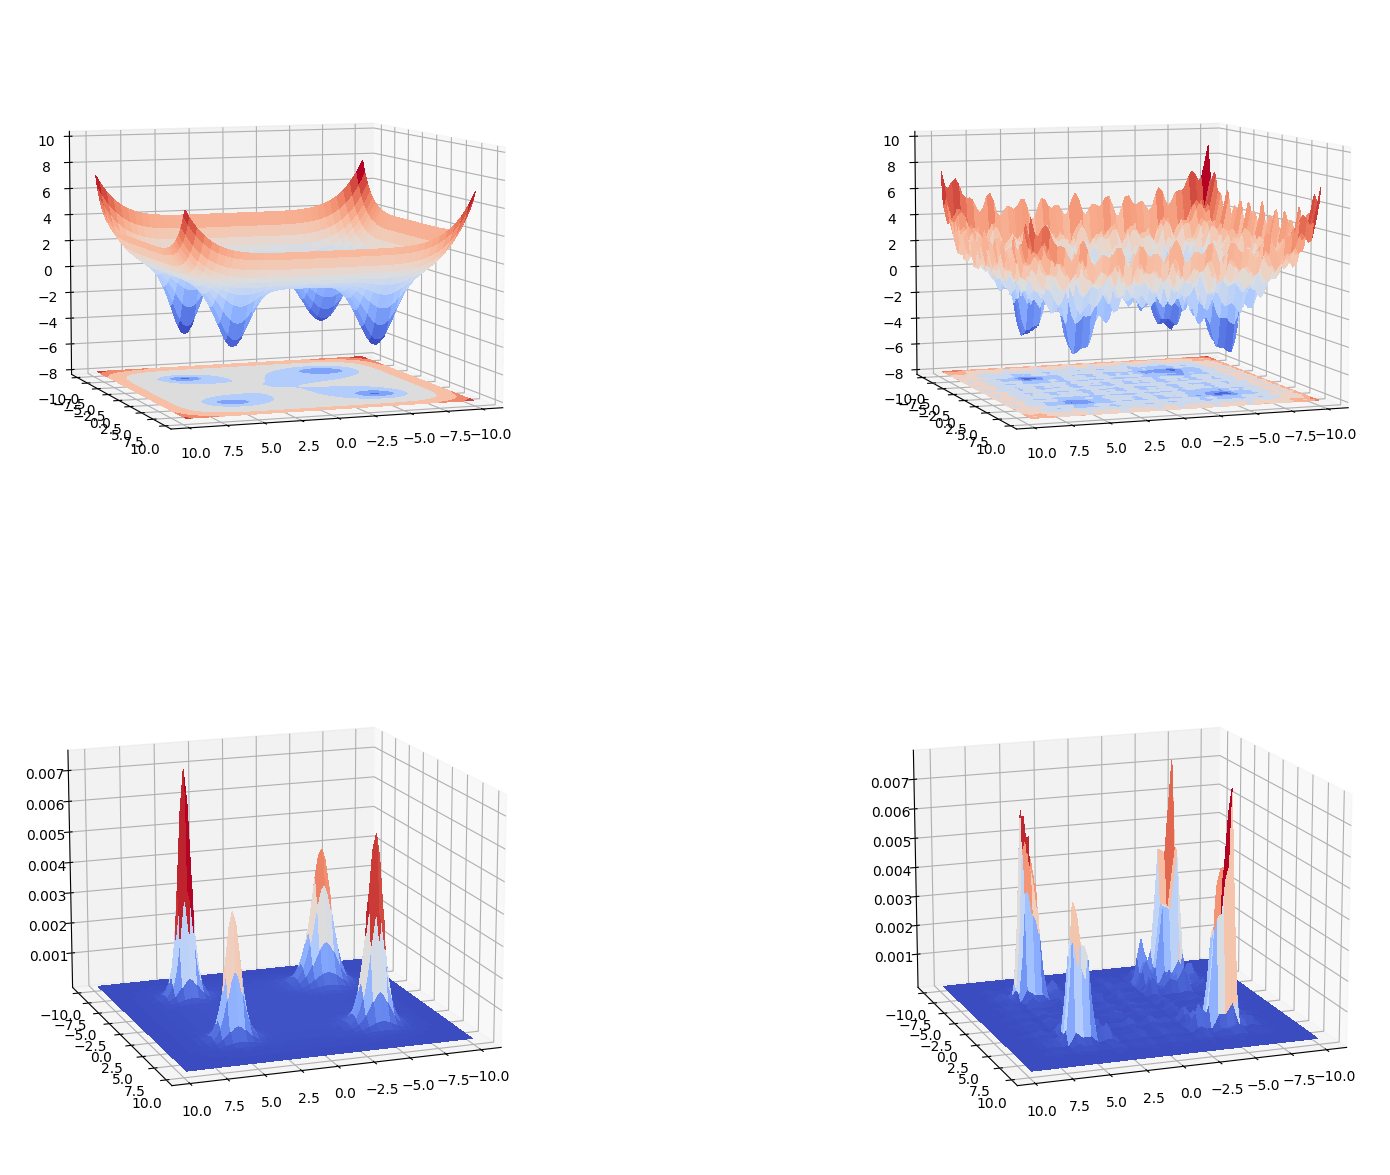

In [6]:
xmin = -10.
xmax =  10.
ymin = -10.
ymax =  10.
X = np.arange(xmin, xmax, 0.25)
Y = np.arange(ymin, ymax, 0.25)
X, Y = np.meshgrid(X, Y)
# Flatten and stack
xy = np.column_stack([X.ravel(), Y.ravel()])

ysc = v_smooth.V(xy)
ysc = ysc.reshape(X.shape)
yfa = v_rugged.V(xy)
yfa = yfa.reshape(X.shape)

psc = np.exp(-ysc)
psc /= np.sum(psc)
pfa = np.exp(-yfa)
pfa /= np.sum(pfa)


#fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#plt.subplot(2,2,1)
fig, ax = plt.subplots(2, 2, figsize=(20, 15), subplot_kw={"projection": "3d"})
ax[0,0].view_init(7, 70)
ax[0,0].plot_surface(X, Y, ysc, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[0,0].contourf(X, Y, ysc, zdir='z', offset=-8, cmap=cm.coolwarm)
ax[0,0].set_zlim(-8, 10)
#ax.contour(X, Y, Z, zdir='z', offset=-5, colors='k')

ax[0,1].view_init(7, 70)
ax[0,1].plot_surface(X, Y, yfa, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[0,1].contourf(X, Y, yfa, zdir='z', offset=-8, cmap=cm.coolwarm)
ax[0,1].set_zlim(-8, 10)

ax[1,0].view_init(15, 70)
ax[1,0].plot_surface(X, Y, psc, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[1,0].contourf(X, Y, psc, zdir='z', offset=-0.5, cmap=cm.coolwarm)

ax[1,1].view_init(15, 70)
ax[1,1].plot_surface(X, Y, pfa, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[1,1].contourf(X, Y, pfa, zdir='z', offset=-0.5, cmap=cm.coolwarm)

#plt.subplot(2,2,4)
#plt.scatter(xrange, pfa, color="black", s=2)
#plt.subplot(2,2,1)
#plt.scatter(xrange, fsc, color="red", s=1)
#plt.subplot(2,2,2)
#plt.scatter(xrange, ffa, color="red", s=1)

------------------------------

## 'Exact' free energy computation
We will compute the thermodynmic properties for all four wells separately using numerical integration.

### Defintion of four regions

In [7]:
reg_A_min_x = -10.0
reg_A_max_x =   0.0
reg_A_min_y = -10.0
reg_A_max_y =   0.0

reg_B_min_x =   0.0
reg_B_max_x =  10.0
reg_B_min_y = -10.0
reg_B_max_y =   0.0

reg_C_min_x = -10.0
reg_C_max_x =   0.0
reg_C_min_y =   0.0
reg_C_max_y =  10.0

reg_D_min_x =   0.0
reg_D_max_x =  10.0
reg_D_min_y =   0.0
reg_D_max_y =  10.0

ranges_modes = [[[reg_A_min_x, reg_A_max_x], [reg_A_min_y, reg_A_max_y]],
                [[reg_B_min_x, reg_B_max_x], [reg_B_min_y, reg_B_max_y]],
                [[reg_C_min_x, reg_C_max_x], [reg_C_min_y, reg_C_max_y]],
                [[reg_D_min_x, reg_D_max_x], [reg_D_min_y, reg_D_max_y]]]

grid_length = 10.0

grid_resolution = 500

slice_width = (grid_length/grid_resolution)


In [8]:
temperature = 1.0   # factor of 298K
m = 10.0             # Mass in amu

### Function to compute potential energy in 2D for discrete points in defined interval

In [9]:
def sample_energy_2D(energy, min_x, max_x, min_y, max_y, resolution, dim=2):
    """ Plot energy functions in 2D """
    positions_x = np.linspace(min_x, max_x, resolution)
    positions_y = np.linspace(min_y, max_y, resolution)
    x_positions, y_positions = np.meshgrid(positions_x,positions_y)
    xs = np.column_stack([x_positions.ravel(), y_positions.ravel()])
    #xs = np.array([x_positions.flatten(), y_positions.flatten()])
    us = energy.V(xs)

    return xs, us

### Function to compute thermodynamic quantities by numerical integration over discrete points in defined interval

In [10]:
def compute_stats(energy, slice_width, dim=2):
    dx = np.power([slice_width], dim)
    
    boltz = np.exp(-energy/(temperature*cf_kT))

    Z_pos = np.sum(boltz)*dx                # positional Z
    Z_mom = 0.9888*np.sqrt(temperature*m)   # momentum Z
    Z = Z_pos*Z_mom
    
    prob = boltz/Z_pos

    min_en = np.min(energy)
    av_en_pos = np.sum(prob*energy)*dx
    av_en_mom = 0.5*temperature*cf_kT
    av_en = av_en_pos + av_en_mom

    prob_pos = prob[np.where(prob>0.0001*dx)]

    TS_pos = -temperature*cf_kT*np.sum(prob_pos*np.log(prob_pos))*dx
    TS_mom = 0.5*temperature*cf_kT*(1 + np.log(0.9888*0.9888*temperature*m))
    TS = TS_pos + TS_mom

    fe_pos = -temperature*cf_kT*np.log(Z_pos)
    fe_mom = -temperature*cf_kT*np.log(Z_mom)
    fe = -temperature*cf_kT*np.log(Z)

    print("Minimum energy : % 6.3f" % min_en)
    print("Average energy : % 6.3f (% 6.3f, % 6.3f)" % (av_en, av_en_mom, av_en_pos))
    print("Entropy        : % 6.3f (% 6.3f, % 6.3f)" % (TS, TS_mom, TS_pos))
    print("Free energy    : % 6.3f (% 6.3f, % 6.3f)" % (fe, fe_mom, fe_pos))
    
    return prob, fe, min_en, av_en, TS

### Compute thermodnamic values for smooth potential for all wells

In [11]:
fe_smooth = []
av_en_smooth = []
ts_smooth = []
min_en_smooth = []

print("Mode A")
_, en1 = sample_energy_2D(energy=v_smooth, min_x=reg_A_min_x, max_x=reg_A_max_x, min_y=reg_A_min_y, max_y=reg_A_max_y, resolution=grid_resolution, dim=2)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_smooth.append(fe)
av_en_smooth.append(av_en)
ts_smooth.append(ts)
min_en_smooth.append(min_en)

print("Mode B")
_, en1 = sample_energy_2D(energy=v_smooth, min_x=reg_B_min_x, max_x=reg_B_max_x, min_y=reg_B_min_y, max_y=reg_B_max_y, resolution=grid_resolution, dim=2)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_smooth.append(fe)
av_en_smooth.append(av_en)
ts_smooth.append(ts)
min_en_smooth.append(min_en)

print("Mode C")
_, en1 = sample_energy_2D(energy=v_smooth, min_x=reg_C_min_x, max_x=reg_C_max_x, min_y=reg_C_min_y, max_y=reg_C_max_y, resolution=grid_resolution, dim=2)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_smooth.append(fe)
av_en_smooth.append(av_en)
ts_smooth.append(ts)
min_en_smooth.append(min_en)

print("Mode D")
_, en1 = sample_energy_2D(energy=v_smooth, min_x=reg_D_min_x, max_x=reg_D_max_x, min_y=reg_D_min_y, max_y=reg_D_max_y, resolution=grid_resolution, dim=2)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_smooth.append(fe)
av_en_smooth.append(av_en)
ts_smooth.append(ts)
min_en_smooth.append(min_en)


Mode A
Minimum energy : -4.083
Average energy : -3.002 ( 0.296, -3.298)
Entropy        :  2.134 ( 0.971,  1.164)
Free energy    : -5.137 (-0.675, -4.462)
Mode B
Minimum energy : -4.582
Average energy : -3.476 ( 0.296, -3.772)
Entropy        :  1.610 ( 0.971,  0.639)
Free energy    : -5.086 (-0.675, -4.411)
Mode C
Minimum energy : -4.382
Average energy : -3.297 ( 0.296, -3.593)
Entropy        :  1.875 ( 0.971,  0.904)
Free energy    : -5.172 (-0.675, -4.497)
Mode D
Minimum energy : -3.982
Average energy : -2.803 ( 0.296, -3.099)
Entropy        :  1.894 ( 0.971,  0.924)
Free energy    : -4.697 (-0.675, -4.022)


<div class="alert alert-warning">Please discuss the following points:<br>
* The momentum contributions to the free energy, entropy and average energy are the same for all four modes. Why?<br>
* What does this mean for calculating free energy differences between different modes or between bound and unbound complex?</div>

### Compute thermodnamic values for rugged potential for all wells

In [12]:
fe_rugged = []
av_en_rugged = []
ts_rugged = []
min_en_rugged = []

print("Mode A")
_, en1 = sample_energy_2D(energy=v_rugged, min_x=reg_A_min_x, max_x=reg_A_max_x, min_y=reg_A_min_y, max_y=reg_A_max_y, resolution=grid_resolution, dim=2)
slice_width = (grid_length/grid_resolution)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_rugged.append(fe)
av_en_rugged.append(av_en)
ts_rugged.append(ts)
min_en_rugged.append(min_en)

print("Mode B")
_, en1 = sample_energy_2D(energy=v_rugged, min_x=reg_B_min_x, max_x=reg_B_max_x, min_y=reg_B_min_y, max_y=reg_B_max_y, resolution=grid_resolution, dim=2)
slice_width = (grid_length/grid_resolution)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_rugged.append(fe)
av_en_rugged.append(av_en)
ts_rugged.append(ts)
min_en_rugged.append(min_en)

print("Mode C")
_, en1 = sample_energy_2D(energy=v_rugged, min_x=reg_C_min_x, max_x=reg_C_max_x, min_y=reg_C_min_y, max_y=reg_C_max_y, resolution=grid_resolution, dim=2)
slice_width = (grid_length/grid_resolution)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_rugged.append(fe)
av_en_rugged.append(av_en)
ts_rugged.append(ts)
min_en_rugged.append(min_en)

print("Mode D")
_, en1 = sample_energy_2D(energy=v_rugged, min_x=reg_D_min_x, max_x=reg_D_max_x, min_y=reg_D_min_y, max_y=reg_D_max_y, resolution=grid_resolution, dim=2)
slice_width = (grid_length/grid_resolution)
prob, fe, min_en, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=2)
fe_rugged.append(fe)
av_en_rugged.append(av_en)
ts_rugged.append(ts)
min_en_rugged.append(min_en)

Mode A
Minimum energy : -4.881
Average energy : -3.574 ( 0.296, -3.870)
Entropy        :  1.921 ( 0.971,  0.950)
Free energy    : -5.495 (-0.675, -4.820)
Mode B
Minimum energy : -4.845
Average energy : -3.816 ( 0.296, -4.112)
Entropy        :  1.597 ( 0.971,  0.626)
Free energy    : -5.413 (-0.675, -4.738)
Mode C
Minimum energy : -4.953
Average energy : -3.797 ( 0.296, -4.093)
Entropy        :  1.734 ( 0.971,  0.763)
Free energy    : -5.531 (-0.675, -4.856)
Mode D
Minimum energy : -4.452
Average energy : -3.262 ( 0.296, -3.558)
Entropy        :  1.788 ( 0.971,  0.817)
Free energy    : -5.050 (-0.675, -4.375)


---------------------------

# Docking
We will simulate the results of docking by randomly selecting a coordinate within each region defining the four modes and minimizing to the nearest local minimum

#### Perform docking 10-times in smooth potential

In [13]:
from scipy.optimize import minimize

# Random selection of starting point within each mode
uncertainty = 1.0
trials = 10

docking_scores = np.zeros((trials,4))

for ti in range(trials):
    for rii, ri in enumerate(scc):
        x0 = ri + (2*np.random.rand(2) - 1.0)*uncertainty
        res = minimize(v_smooth.V, x0, method='BFGS')
        docking_scores[ti,rii] = res.fun


#### Compare docking results with ground truth data

/tmp/ipykernel_1911/3879398996.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(x_vals, min_indices, c=[colors[i] for i in min_indices], cmap='tab10', marker='o')


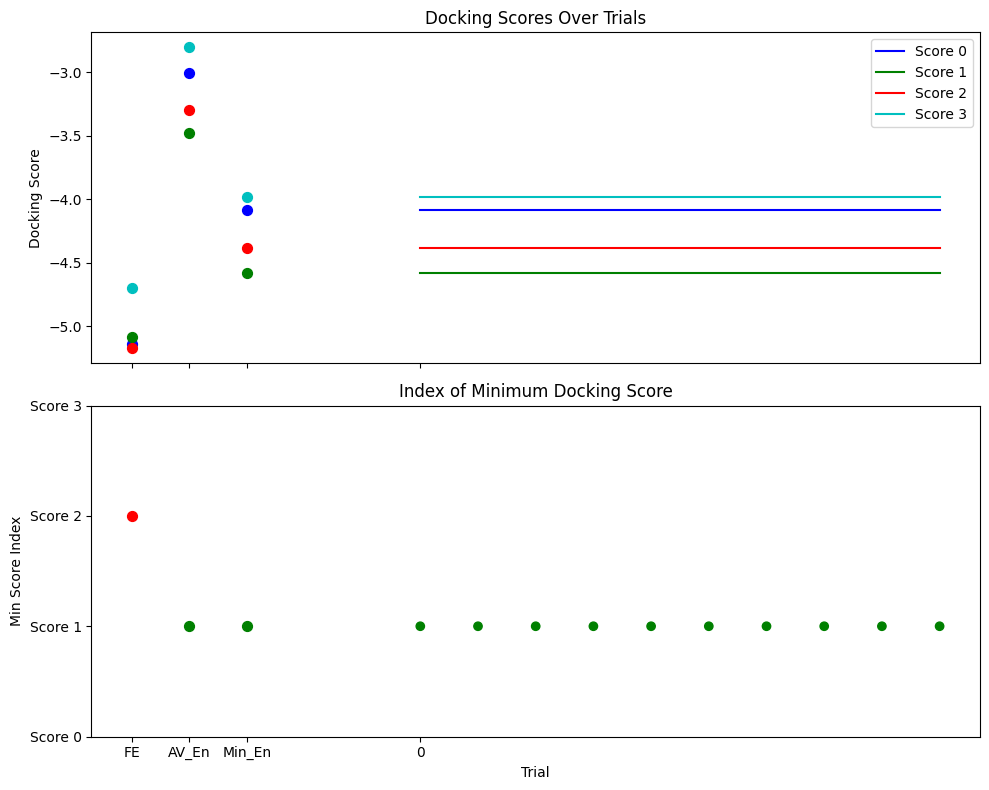

In [14]:
# Compute the indices of the minimum values along axis 1
min_indices = np.argmin(docking_scores, axis=1)

# minimum index for FE, AV_En and Min_En
min_ind_fe     = np.argmin(fe_smooth)
min_ind_av_en  = np.argmin(av_en_smooth)
min_ind_min_en = np.argmin(min_en_smooth)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Define colors for consistency
colors = ['b', 'g', 'r', 'c']

# First subplot: Plot all four scores as lines
x_vals = np.arange(trials)
for i in range(4):
    axes[0].plot(x_vals, docking_scores[:, i], label=f"Score {i}", color=colors[i])

# Add individual points on the left side
x_positions = [-5, -4, -3]  # X positions for fe_smooth, av_en_smooth, min_en_smooth
labels = ["FE", "AV_En", "Min_En"]
values = [fe_smooth, av_en_smooth, min_en_smooth]

for x_pos, label, vals in zip(x_positions, labels, values):
    for i in range(4):
        axes[0].scatter(x_pos, vals[i], color=colors[i], marker='o', s=50)

# Formatting first subplot
axes[0].set_xticks(list(x_positions) + list(range(0, trials, 10)))  # Show left-side points
axes[0].set_xticklabels(labels + [str(i) for i in range(0, trials, 10)])
axes[0].set_ylabel("Docking Score")
axes[0].legend()
axes[0].set_title("Docking Scores Over Trials")

values_ind = [min_ind_fe, min_ind_av_en, min_ind_min_en]
for x_pos, label, vals in zip(x_positions, labels, values_ind):
    axes[1].scatter(x_pos, vals, color=colors[vals], marker='o', s=50)

# Second subplot: Plot the min index as discrete values
axes[1].scatter(x_vals, min_indices, c=[colors[i] for i in min_indices], cmap='tab10', marker='o')
axes[1].set_yticks(range(4))
axes[1].set_yticklabels([f"Score {i}" for i in range(4)])
axes[1].set_ylabel("Min Score Index")
axes[1].set_xlabel("Trial")
axes[1].set_title("Index of Minimum Docking Score")

plt.tight_layout()
plt.show()

<div class="alert alert-warning">Please discuss the following points:<br>
* The docking runs all end up with the same results. Why?<br>
* Why do the docking run predict a different binding mode than the ground truth data?</div>

#### Perform docking 10-times in rough potential

In [15]:
# Random selection of starting point within each mode
uncertainty = 1.0
trials = 10

docking_scores = np.zeros((trials,4))

for ti in range(trials):
    for rii, ri in enumerate(scc):
        x0 = ri + (2*np.random.rand(2) - 1.0)*uncertainty
        res = minimize(v_rugged.V, x0, method='BFGS')
        docking_scores[ti,rii] = res.fun


#### Compare docking results with ground truth data

/tmp/ipykernel_1911/3897248442.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(x_vals, min_indices, c=[colors[i] for i in min_indices], cmap='tab10', marker='o')


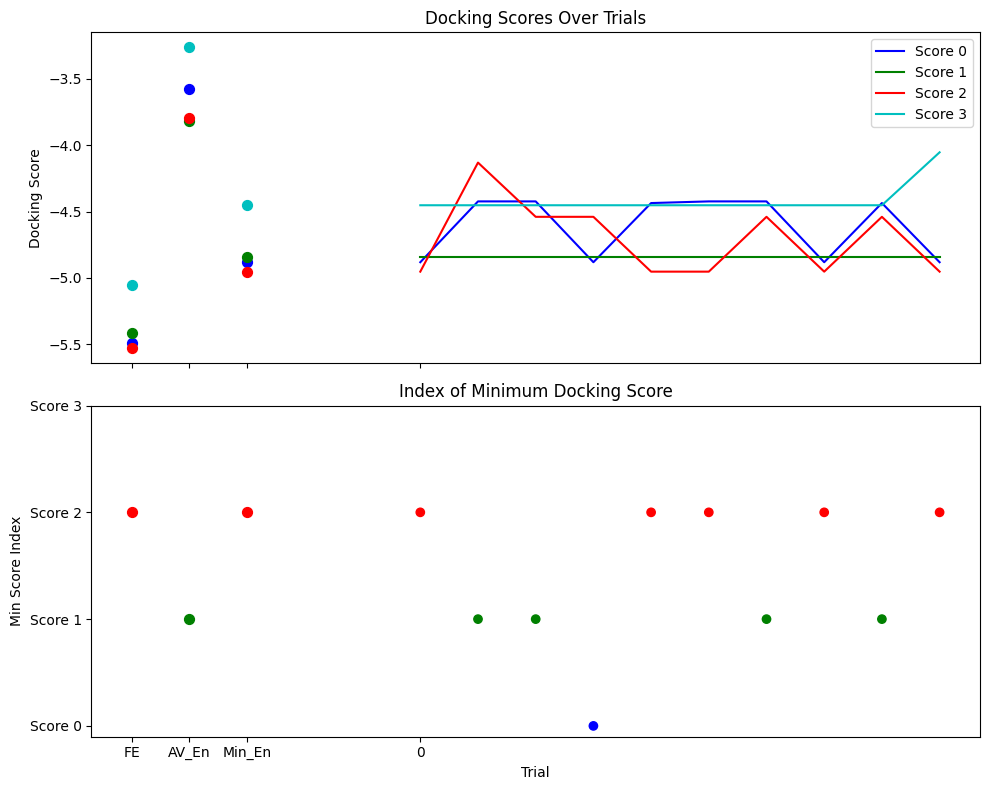

In [16]:
# Compute the indices of the minimum values along axis 1
min_indices = np.argmin(docking_scores, axis=1)

# minimum index for FE, AV_En and Min_En
min_ind_fe     = np.argmin(fe_rugged)
min_ind_av_en  = np.argmin(av_en_rugged)
min_ind_min_en = np.argmin(min_en_rugged)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Define colors for consistency
colors = ['b', 'g', 'r', 'c']

# First subplot: Plot all four scores as lines
x_vals = np.arange(trials)
for i in range(4):
    axes[0].plot(x_vals, docking_scores[:, i], label=f"Score {i}", color=colors[i])

# Add individual points on the left side
x_positions = [-5, -4, -3]  # X positions for fe_rugged, av_en_rugged, min_en_rugged
labels = ["FE", "AV_En", "Min_En"]
values = [fe_rugged, av_en_rugged, min_en_rugged]

for x_pos, label, vals in zip(x_positions, labels, values):
    for i in range(4):
        axes[0].scatter(x_pos, vals[i], color=colors[i], marker='o', s=50)

# Formatting first subplot
axes[0].set_xticks(list(x_positions) + list(range(0, trials, 10)))  # Show left-side points
axes[0].set_xticklabels(labels + [str(i) for i in range(0, trials, 10)])
axes[0].set_ylabel("Docking Score")
axes[0].legend()
axes[0].set_title("Docking Scores Over Trials")

values_ind = [min_ind_fe, min_ind_av_en, min_ind_min_en]
for x_pos, label, vals in zip(x_positions, labels, values_ind):
    axes[1].scatter(x_pos, vals, color=colors[vals], marker='o', s=50)

# Second subplot: Plot the min index as discrete values
axes[1].scatter(x_vals, min_indices, c=[colors[i] for i in min_indices], cmap='tab10', marker='o')
axes[1].set_yticks(range(4))
axes[1].set_yticklabels([f"Score {i}" for i in range(4)])
axes[1].set_ylabel("Min Score Index")
axes[1].set_xlabel("Trial")
axes[1].set_title("Index of Minimum Docking Score")

plt.tight_layout()
plt.show()

<div class="alert alert-warning">Please discuss the following points:<br>
* The docking runs end up with different results (in contrast to docking to the smooth potential). Why?<br>
* How can we potentially overcome this divergence in results?</div>

***

# We will now perform MD simulations starting from different starting poses.<br>
This may resemble post-processing on different docking poses.

### Analysis tools for MD sampling

In [17]:
def samples2density(xs, extent, resolution, slice_width):
    dx = np.power([slice_width], 2)

    min_x, max_x = extent[0]
    min_y, max_y = extent[1]

    # histogram: accumulate densities
    num_samples = xs.shape[0]
    prob = np.zeros([resolution, resolution])

    bins = [resolution, resolution]
    ranges = [[min_x, max_x], [min_y, max_y]]
    #print(xs, bins, ranges)

    prob, _ = np.histogramdd(xs, bins=bins, range=ranges, density=False)
        
    prob = prob/num_samples 
    prob = prob/dx
    #print(torch.sum(prob))
    
    return prob  

def compute_stats_samples(energy, prob, slice_width):
    dx = np.power([slice_width], 2)

    av_en_pos = np.mean(energy)
    av_en_mom = 0.5*temperature*cf_kT
    av_en = av_en_pos + av_en_mom

    prob_pos = prob[np.where(prob>0.0000001)]


    TS_pos = -temperature*cf_kT*np.sum(prob_pos*np.log(prob_pos))*dx
    TS_mom = 0.5*temperature*cf_kT*(1 + np.log(0.9888*0.9888*temperature*m))
    TS = TS_pos + TS_mom
    
    fe = av_en - TS

    #print("Average energy : %.3f" % av_en)
    #print("Entropy        : %.3f" % TS)
    #print("Free energy    : %.3f" % fe)
    
    return fe, av_en, TS


## Sampling using MD (Langevin dynamics)

In [18]:
# Langevin integration parameters
dt = 2.0                # Time step in fs
gamma = 0.001           # Friction coefficient in 1/fs
kT = temperature*cf_kT  # Thermal energy (Boltzmann constant * temperature)


sigma = 0.02261 * np.sqrt(gamma * temperature * dt / m)  # Noise strength
cf_accel = 0.000418

num_steps_equ = 1000
num_steps = 1000
num_samples = 100
num_trials_per_mode = 3


In [19]:
def langevin(x, v, f, dt=0.01):
    # Generate random force (Gaussian noise)
    eta = np.random.normal(0, sigma, size=x.shape)
    
    # Velocity update (half step)
    v += (cf_accel * f / m - gamma * v) * dt + eta
    
    # Position update (full step)
    x += v * dt
    #print(x, f*delta,  np.random.randn(2))
    
    return x, v

#### MD in smooth potential

In [20]:
# Random selection of starting point within each mode
uncertainty = 1.0

x_store_sc = np.zeros((4, num_trials_per_mode, num_steps, num_samples, 2))


for rii, ri in enumerate(scc):  # loop over all 4 modes
    for ti in range(num_trials_per_mode):   # loop over different trials
        # starting coordinates
        x0 = ri + (2*np.random.rand(num_samples,2) - 1.0)*uncertainty

        x_cur_l = np.full((num_samples,2), x0)
        v_cur_l = np.zeros((num_samples,2))

        # run simulation: first equilibration, second production
        for i in range(num_steps_equ):
            ff = v_smooth.F(x_cur_l)
            x_cur_l, v_cur_l = langevin(x_cur_l, v_cur_l, ff, dt)

        for i in range(num_steps):
            ff = v_smooth.F(x_cur_l)
            x_cur_l, v_cur_l = langevin(x_cur_l, v_cur_l, ff, dt)
            x_store_sc[rii, ti, i] = x_cur_l

x_store_sc = x_store_sc.reshape((4, num_trials_per_mode*num_steps*num_samples,2))


### Compute thermodynamic properties
First we convert the samples into probability density $p(x)$ with same bin width used for direct numerical integration over $x$ to obtain the thermodnamic properties.<br>
Next we compute average energy over all samples and entropy from $p(x)$.<br>
Finally the free energy is computed using $F = <E> - TS$.

In [21]:
for rii, ri in enumerate(scc):  # loop over all 4 modes
    print("Mode %d" % rii)
    prob_md = samples2density(xs=x_store_sc[rii], extent=ranges_modes[rii], resolution=grid_resolution, slice_width=slice_width)
    U_samples = v_smooth.V(x_store_sc[rii])
    fe, av_en, TS = compute_stats_samples(energy=U_samples, prob=prob_md, slice_width=slice_width)
    print("Average energy : % 6.3f (% 6.3f)" % (av_en, av_en_smooth[rii]))
    print("Entropy        : % 6.3f (% 6.3f)" % (TS, ts_smooth[rii]))
    print("Free energy    : % 6.3f (% 6.3f)" % (fe, fe_smooth[rii]))



Mode 0
Average energy : -3.006 (-3.002)
Entropy        :  1.998 ( 2.134)
Free energy    : -5.004 (-5.137)
Mode 1
Average energy : -3.488 (-3.476)
Entropy        :  1.521 ( 1.610)
Free energy    : -5.008 (-5.086)
Mode 2
Average energy : -3.302 (-3.297)
Entropy        :  1.771 ( 1.875)
Free energy    : -5.073 (-5.172)
Mode 3
Average energy : -2.886 (-2.803)
Entropy        :  1.667 ( 1.894)
Free energy    : -4.553 (-4.697)


<div class="alert alert-warning">Please discuss why the entropy is underestimated for all four modes.<br>
What would you change in the simulation settings?
</div>


----------------------

#### Plot md results in comparison with ground truth and docking

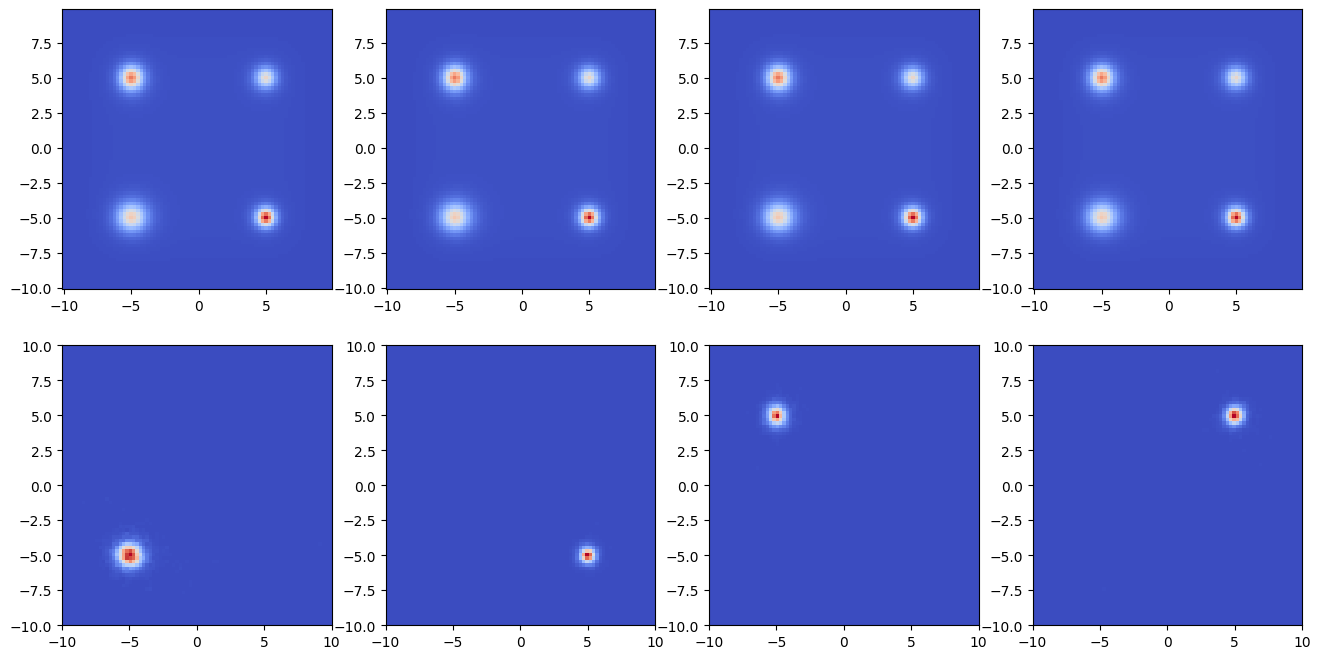

In [22]:
from scipy.stats import kde

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0,0].pcolormesh(X, Y, psc, cmap=cm.coolwarm)
ax[0,1].pcolormesh(X, Y, psc, cmap=cm.coolwarm)
ax[0,2].pcolormesh(X, Y, psc, cmap=cm.coolwarm)
ax[0,3].pcolormesh(X, Y, psc, cmap=cm.coolwarm)

ax[1,0].hist2d(x_store_sc[0,:,0], x_store_sc[0,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);
ax[1,1].hist2d(x_store_sc[1,:,0], x_store_sc[1,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);
ax[1,2].hist2d(x_store_sc[2,:,0], x_store_sc[2,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);
ax[1,3].hist2d(x_store_sc[3,:,0], x_store_sc[3,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);

***

### MD in rugged potential

In [23]:
# Random selection of starting point within each mode
uncertainty = 1.0

x_store_fa = np.zeros((4, num_trials_per_mode, num_steps, num_samples, 2))


for rii, ri in enumerate(scc):  # loop over all 4 modes
    for ti in range(num_trials_per_mode):   # loop over different trials
        # starting coordinates
        x0 = ri + (2*np.random.rand(num_samples, 2) - 1.0)*uncertainty
        #y0 = ri[1] + (2*np.random.rand(num_samples) - 1.0)*uncertainty

        x_cur_l = np.full((num_samples,2), x0)
        v_cur_l = np.zeros((num_samples,2))

        # run simulation: first equilibration, second production
        for i in range(num_steps_equ):
            ff = v_rugged.F(x_cur_l)
            x_cur_l, v_cur_l = langevin(x_cur_l, v_cur_l, ff, dt)

        for i in range(num_steps):
            ff = v_rugged.F(x_cur_l)
            x_cur_l, v_cur_l = langevin(x_cur_l, v_cur_l, ff, dt)
            x_store_fa[rii, ti, i] = x_cur_l

x_store_fa = x_store_fa.reshape((4, num_trials_per_mode*num_steps*num_samples,2))


### Compute thermodynamic properties

In [24]:
for rii, ri in enumerate(scc):  # loop over all 4 modes
    print("Mode %d" % rii)
    prob_md = samples2density(xs=x_store_fa[rii], extent=ranges_modes[rii], resolution=grid_resolution, slice_width=slice_width)
    U_samples = v_rugged.V(x_store_fa[rii])
    fe, av_en, TS = compute_stats_samples(energy=U_samples, prob=prob_md, slice_width=slice_width)
    print("Average energy : % 6.3f (% 6.3f)" % (av_en, av_en_rugged[rii]))
    print("Entropy        : % 6.3f (% 6.3f)" % (TS, ts_rugged[rii]))
    print("Free energy    : % 6.3f (% 6.3f)" % (fe, fe_rugged[rii]))



Mode 0
Average energy : -3.679 (-3.574)
Entropy        :  1.727 ( 1.921)
Free energy    : -5.406 (-5.495)
Mode 1
Average energy : -3.778 (-3.816)
Entropy        :  1.550 ( 1.597)
Free energy    : -5.327 (-5.413)
Mode 2
Average energy : -3.847 (-3.797)
Entropy        :  1.604 ( 1.734)
Free energy    : -5.452 (-5.531)
Mode 3
Average energy : -3.372 (-3.262)
Entropy        :  1.575 ( 1.788)
Free energy    : -4.947 (-5.050)


(80, 80) (80, 80)


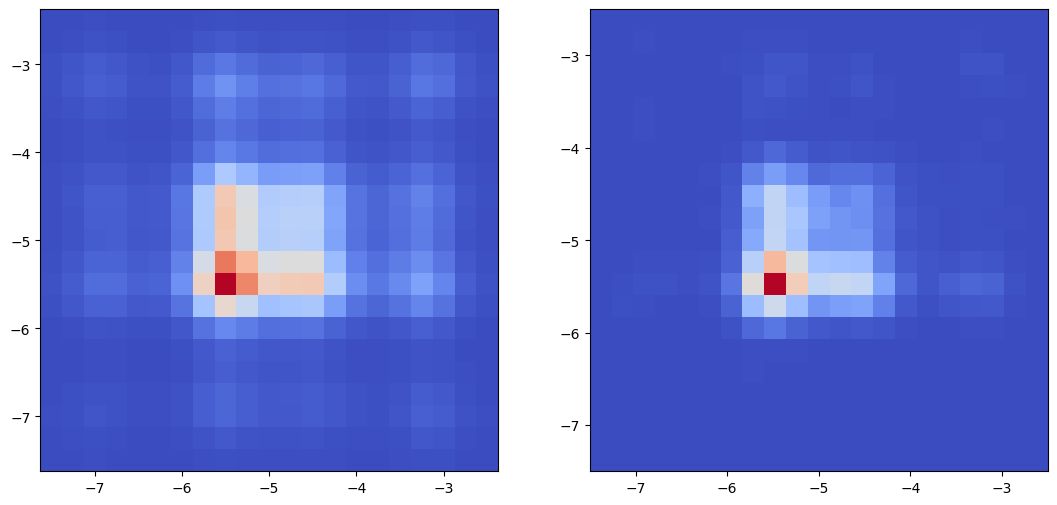

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
print(X.shape, Y.shape)
X_ll = X[10:31, 10:31]
Y_ll = Y[10:31, 10:31]
pfa_ll = 4*pfa[10:31, 10:31]
#print(X[10:30][10:30],Y[10:30][10:30],pfa[10:30][10:30])
#ax[0].pcolormesh(X, Y, pfa, cmap=cm.coolwarm)
ax[0].pcolormesh(X_ll, Y_ll, pfa_ll, cmap=cm.coolwarm)
ax[1].hist2d(x_store_fa[0,:,0], x_store_fa[0,:,1], bins=21, range = [[-7.5, -2.5], [-7.5, -2.5]], cmap=cm.coolwarm);

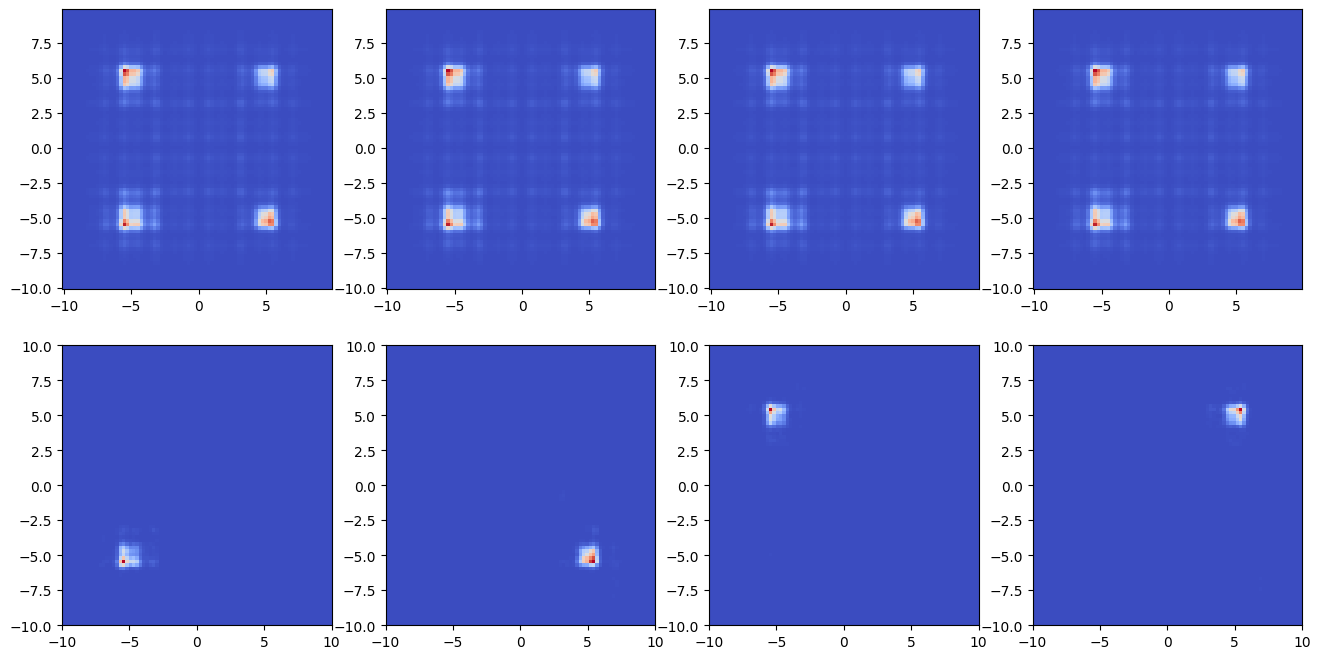

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0,0].pcolormesh(X, Y, pfa, cmap=cm.coolwarm)
ax[0,1].pcolormesh(X, Y, pfa, cmap=cm.coolwarm)
ax[0,2].pcolormesh(X, Y, pfa, cmap=cm.coolwarm)
ax[0,3].pcolormesh(X, Y, pfa, cmap=cm.coolwarm)

ax[1,0].hist2d(x_store_fa[0,:,0], x_store_fa[0,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);
ax[1,1].hist2d(x_store_fa[1,:,0], x_store_fa[1,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);
ax[1,2].hist2d(x_store_fa[2,:,0], x_store_fa[2,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);
ax[1,3].hist2d(x_store_fa[3,:,0], x_store_fa[3,:,1], bins=81, range = [[xmin, xmax], [ymin, ymax]], cmap=cm.coolwarm);

***

### Alternative approach for free energy calculation (focus on entropy):<br>
### (Multi-basin) normal mode analysis or quasi harmonic analysis

Idea: <br>
* Approximate PES by non-overlapping harmonic potential wells
* Compute entropy, average  over individual wells using NMA/QHA
* Add configurational entropy for jumps between wells

### Smooth potential

#### Find minima: Docking + energy minimization

In [27]:
from scipy.optimize import minimize

# Random selection of starting point within each mode
uncertainty = 1.0
trials = 100

minima = np.zeros((4, trials, 2))

for ti in range(trials):
    for rii, ri in enumerate(scc):
        x0 = ri + (2*np.random.rand(2) - 1.0)*uncertainty
        xf = minimize(fun=v_smooth.V, x0=x0, method='BFGS', tol=0.000001)
        minima[rii, ti] = xf.x


#### Cluster minima to find unique local minima

In [28]:
from scipy.spatial.distance import cdist

def get_unique_minima_scipy(minima, threshold=1e-2):
    unique_minima = []
    for min_candidate in minima:
        min_candidate = min_candidate.tolist()
        if len(unique_minima) == 0:
            unique_minima.append(min_candidate)
        else:
            dists = cdist([min_candidate], unique_minima)
            if np.min(dists) > threshold:
                unique_minima.append(min_candidate)
    return unique_minima


In [29]:
unique_minima = [[] for _ in scc]

for rii, ri in enumerate(scc):
    unique_minima[rii] = get_unique_minima_scipy(minima[rii], threshold=0.01)
print(unique_minima)

[[[-4.9670318726565315, -4.9723783921330265]], [[4.987473917258894, -4.98842633034099]], [[-4.98051008298632, 4.980510098582752]], [[4.982847098983145, 4.984382416065526]]]


In [30]:
from scipy.linalg import eigh

# Define a function to compute the Hessian numerically
def compute_hessian_2x2(func, x, epsilon=1e-4):
    n = 2
    hessian = np.zeros((n, n))

    # Additional points for finite difference calculations
    x_pp = np.copy(x)
    x_pp[0] += epsilon
    x_pp[1] += epsilon
    f_pp = func(x_pp)

    x_p0 = np.copy(x)
    x_p0[0] += epsilon
    f_p0 = func(x_p0)

    x_pm = np.copy(x)
    x_pm[0] += epsilon
    x_pm[1] -= epsilon
    f_pm = func(x_pm)

    x_0m = np.copy(x)
    x_0m[1] -= epsilon
    f_0m = func(x_0m)

    f_00 = func(x)

    x_0p = np.copy(x)
    x_0p[1] += epsilon
    f_0p = func(x_0p)

    x_mm = np.copy(x)
    x_mm[0] -= epsilon
    x_mm[1] -= epsilon
    f_mm = func(x_mm)

    x_m0 = np.copy(x)
    x_m0[0] -= epsilon
    f_m0 = func(x_m0)

    x_mp = np.copy(x)
    x_mp[0] -= epsilon
    x_mp[1] += epsilon
    f_mp = func(x_mp)

    # Second derivatives
    hessian[0,0] = (f_p0 - 2*f_00 + f_m0)/(epsilon*epsilon)
    #hessian[0,1] = (f_pp - f_p0 - f_0p + 2*f_00 - f_0m - f_m0 + f_mm)/(2*epsilon*epsilon)
    #hessian[0,1] = (f_pp - f_p0 - f_0p + f_00)/(epsilon*epsilon)
    #print(f_p0, f_00, f_m0, epsilon, f_p0 - 2*f_00 + f_m0, hessian[0,0])
    hessian[0,1] = (f_pp - f_pm - f_mp + f_mm)/(4*epsilon*epsilon)
    hessian[1,0] = hessian[0,1]
    hessian[1,1] = (f_0p - 2*f_00 + f_0m)/(epsilon*epsilon)
  
    return hessian

In [31]:
def get_frequencies(hessian, mass=1.0):
    eigvals = eigh(hessian, eigvals_only=True)
    freqs = np.sqrt(np.abs(eigvals) / mass)  # Take abs to avoid tiny negative eigenvalues
    return freqs

In [32]:


E_harm = np.zeros(4)
TS_harm = np.zeros(4)
F_harm = np.zeros(4)
E_harm_classical = np.zeros(4)
TS_harm_classical = np.zeros(4)
F_harm_classical = np.zeros(4)
for rii, ri in enumerate(scc):
    Z_i = np.ones(len(unique_minima[rii]))
    E_min_i = np.ones(len(unique_minima[rii]))
    Z_sum = 0.0
    freqs = []
    for uii, ui in enumerate(unique_minima[rii]):
        E_min_i[uii] = v_smooth.V(np.asarray(ui))
        hess = compute_hessian_2x2(v_smooth.V, np.asarray(ui), epsilon=1e-3)
        #print(hess)
        freqs.append(get_frequencies(hess, mass=m))
        #print(freqs)
        # calculate partition function for each minima first as this gives us the relative probability of the different minima
        for fr in freqs[uii]:
            xxx = fr*cf_hbar_omega_over_kT/temperature
            Z_i[uii] *= 1/xxx
        Z_i[uii] *= np.exp(-E_min_i[uii]/(temperature*cf_kT))
        Z_sum += Z_i[uii]

    # compute relative probability of each local minimum
    p_i = np.zeros(len(unique_minima[rii]))
    for uii, ui in enumerate(unique_minima[rii]):
        p_i[uii] = Z_i[uii]/Z_sum
    #print(p_i, E_min_i)

    for uii, ui in enumerate(unique_minima[rii]):
        E_min = E_min_i[uii]
        tmp_E = 0.0
        tmp_E_classical = 0.0
        tmp_F_classical = 0.0
        for fr in freqs[uii]:
            xxx = fr*cf_hbar_omega_over_kT/temperature

            tmp_E += p_i[uii] * ( 0.5*fr*cf_hbar_omega + fr*cf_hbar_omega/(np.exp(xxx) - 1) )
            tmp_E_classical += p_i[uii] * ( temperature*cf_kT )
            TS_harm[rii] += p_i[uii] * ( temperature*cf_kT * (xxx/(np.exp(xxx) - 1) - np.log(1 - np.exp(-xxx))) )
            TS_harm_classical[rii] += p_i[uii] * ( temperature*cf_kT*(1 - np.log(xxx)) )
            tmp_F_classical += p_i[uii] * ( temperature*cf_kT*np.log(xxx) )
        E_harm[rii] += p_i[uii] * E_min + tmp_E
        E_harm_classical[rii] += p_i[uii] * E_min + tmp_E_classical
        F_harm_classical[rii] += p_i[uii] * E_min + tmp_F_classical
    F_harm[rii] = E_harm[rii] - TS_harm[rii]
    #F_harm_classical[rii] = E_harm_classical[rii] - TS_harm_classical[rii]
    print("Mode %d" % rii)
    print("Average energy QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (E_harm[rii], E_harm_classical[rii], av_en_smooth[rii]))
    print("Entropy        QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (TS_harm[rii], TS_harm_classical[rii], ts_smooth[rii]))
    print("Free energy    QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (F_harm[rii], F_harm_classical[rii], fe_smooth[rii]))

# difference to mode 0
print("\n\n Differences")
for rii, ri in enumerate(scc):
    if rii >= 1:
        print("Mode %d" % rii)
        print("Average energy QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (E_harm[rii] - E_harm[0], E_harm_classical[rii] - E_harm_classical[0], av_en_smooth[rii] - av_en_smooth[0]))
        print("Entropy        QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (TS_harm[rii] - TS_harm[0], TS_harm_classical[rii] - TS_harm_classical[0], ts_smooth[rii] - ts_smooth[0]))
        print("Free energy    QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (F_harm[rii] - F_harm[0], F_harm_classical[rii] - F_harm_classical[0], fe_smooth[rii] - fe_smooth[0]))


-4.082955689521308 -4.082956773243315 -4.082955689499573 0.001 2.1674657491033145e-06 2.1674657491033145
[array([0.46556016, 0.50867933])]
Mode 0
Average energy QM/classical : -2.893/-2.899 (-3.002)
Entropy        QM/classical :  2.804/ 2.801 ( 2.134)
Free energy    QM/classical : -5.697/-5.700 (-5.137)
-4.581649631352502 -4.581652485578084 -4.581649631077493 0.001 5.70872617178253e-06 5.70872617178253
[array([0.75556097, 0.78604677])]
Mode 1
Average energy QM/classical : -3.382/-3.398 (-3.476)
Entropy        QM/classical :  2.265/ 2.256 ( 1.610)
Free energy    QM/classical : -5.646/-5.654 (-5.086)
-4.38218262571397 -4.3821844598018505 -4.382182625661068 0.001 3.66822866304517e-06 3.66822866304517
[array([0.60556874, 0.60574931])]
Mode 2
Average energy QM/classical : -3.188/-3.198 (-3.297)
Entropy        QM/classical :  2.547/ 2.542 ( 1.875)
Free energy    QM/classical : -5.735/-5.740 (-5.172)
-3.981960385655475 -3.9819624697694533 -3.981960385694316 0.001 4.168189115638654e-06 4.16818

### Rugged potential

In [33]:
#### Find minima: Docking + energy minimization
from scipy.optimize import minimize

# Random selection of starting point within each mode
uncertainty = 1.0
trials = 200

minima = np.zeros((4, trials, 2))

for ti in range(trials):
    for rii, ri in enumerate(scc):
        x0 = ri + (2*np.random.rand(2) - 1.0)*uncertainty
        xf = minimize(fun=v_rugged.V, x0=x0, method='BFGS')
        minima[rii, ti] = xf.x


unique_minima = [[] for _ in scc]

for rii, ri in enumerate(scc):
    unique_minima[rii] = get_unique_minima_scipy(minima[rii], threshold=0.01)
print(unique_minima)




E_harm = np.zeros(4)
TS_harm = np.zeros(4)
F_harm = np.zeros(4)
E_harm_classical = np.zeros(4)
TS_harm_classical = np.zeros(4)
F_harm_classical = np.zeros(4)
for rii, ri in enumerate(scc):
    Z_i = np.ones(len(unique_minima[rii]))
    E_min_i = np.ones(len(unique_minima[rii]))
    Z_sum = 0.0
    freqs = []
    for uii, ui in enumerate(unique_minima[rii]):
        E_min_i[uii] = v_rugged.V(np.asarray(ui))
        hess = compute_hessian_2x2(v_rugged.V, np.asarray(ui), epsilon=1e-4)
        #print(hess)
        freqs.append(get_frequencies(hess, mass=m))
        #print(freqs)
        # calculate partition function for each minima first as this gives us the relative probability of the different minima
        for fr in freqs[uii]:
            xxx = fr*cf_hbar_omega_over_kT/temperature
            Z_i[uii] *= 1/xxx
        Z_i[uii] *= np.exp(-E_min_i[uii]/(temperature*cf_kT))
        Z_sum += Z_i[uii]

    # compute relative probability of each local minimum
    p_i = np.zeros(len(unique_minima[rii]))
    for uii, ui in enumerate(unique_minima[rii]):
        p_i[uii] = Z_i[uii]/Z_sum
    #print(p_i, E_min_i)

    TS_conf = 0.0
    for uii, ui in enumerate(unique_minima[rii]):
        E_min = E_min_i[uii]
        tmp_E = 0.0
        tmp_E_classical = 0.0
        tmp_F_classical = 0.0
        for fr in freqs[uii]:
            xxx = fr*cf_hbar_omega_over_kT/temperature

            tmp_E += p_i[uii] * ( 0.5*fr*cf_hbar_omega + fr*cf_hbar_omega/(np.exp(xxx) - 1) )
            tmp_E_classical += p_i[uii] * ( temperature*cf_kT )
            TS_harm[rii] += p_i[uii] * ( temperature*cf_kT * (xxx/(np.exp(xxx) - 1) - np.log(1 - np.exp(-xxx))) )
            TS_harm_classical[rii] += p_i[uii] * ( temperature*cf_kT*(1 - np.log(xxx)) )
            tmp_F_classical += p_i[uii] * ( temperature*cf_kT*np.log(xxx) )
        E_harm[rii] += p_i[uii] * E_min + tmp_E
        E_harm_classical[rii] += p_i[uii] * E_min + tmp_E_classical
        F_harm_classical[rii] += p_i[uii] * E_min + tmp_F_classical
        TS_conf += temperature*cf_kT*p_i[uii]*np.log(p_i[uii])

    TS_harm[rii] -= TS_conf
    TS_harm_classical[rii] -= TS_conf

    F_harm[rii] = E_harm[rii] - TS_harm[rii]
    F_harm_classical[rii] = E_harm_classical[rii] - TS_harm_classical[rii]
    print("Mode %d" % rii)
    print("Average energy QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (E_harm[rii], E_harm_classical[rii], av_en_rugged[rii]))
    print("Entropy        QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (TS_harm[rii], TS_harm_classical[rii], ts_rugged[rii]))
    print("Free energy    QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (F_harm[rii], F_harm_classical[rii], fe_rugged[rii]))

# difference to mode 0
print("\n\n Differences")
for rii, ri in enumerate(scc):
    if rii >= 1:
        print("Mode %d" % rii)
        print("Average energy QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (E_harm[rii] - E_harm[0], E_harm_classical[rii] - E_harm_classical[0], av_en_rugged[rii] - av_en_rugged[0]))
        print("Entropy        QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (TS_harm[rii] - TS_harm[0], TS_harm_classical[rii] - TS_harm_classical[0], ts_rugged[rii] - ts_rugged[0]))
        print("Free energy    QM/classical : % 6.3f/% 6.3f (% 6.3f)" % (F_harm[rii] - F_harm[0], F_harm_classical[rii] - F_harm_classical[0], fe_rugged[rii] - fe_rugged[0]))


[[[-4.601534455680316, -5.458238968759629], [-5.4715372553611745, -4.62375513928494], [-5.472986044182611, -5.459576126069689], [-4.603861349108181, -4.626002380881199]], [[5.371535829464296, -5.358014831282684]], [[-5.428875994522935, 5.428875809340346], [-5.425129310480461, 4.680634131324891], [-4.688438508220653, 4.688438454881411], [-4.680634467374029, 5.4251296558626905]], [[4.7075433690852355, 5.399484305415766], [5.417592861065499, 5.405752134704454], [4.726166009384293, 4.765991919771868], [5.410701048040591, 4.740965792996052]]]
-4.423078344550028 -4.423078378983573 -4.423078344358304 0.0001 6.905881377861078e-08 6.905881377861078
[array([0.83055778, 1.12085527])]
-4.435609397631183 -4.435609461746511 -4.435609397629262 0.0001 1.282325765572523e-07 12.823257655725229
[array([0.83055778, 1.12085527]), array([0.79461509, 1.13267681])]
-4.881783314985126 -4.881783378679636 -4.881783313919566 0.0001 1.2845457852961317e-07 12.845457852961317
[array([0.83055778, 1.12085527]), array(